
# PROJE 8: ARAÇLARIN YAKIT TÜKETİMİ TAHMİNİ

Araçların ne kadar yakıt tükettiklerini tahmin edecek algoritmaları geliştireceğimiz bir proje olacak. Bu projeyi geliştirirken farklı algoritmaları kullanacak ve çeşitli tekniklerden yararlanacağız.

## Konu Başlıkları
1. [Python Kütüphaneleri](#1)
1. [Veri Seti ve Problem Tanıtımı](#2)
1. [Imputing Missing Value (Kayıp Veri Sorunu)](#3)
1. [Keşifsel-Açıklayıcı Veri Analizi (Exploratory Data Science)](#4)
1. [Outlier'ların Tespiti ve Çıkarılması](#5)
1. [Feature Enginnering (Öz Nitelik Mühendisliği): Skewness (Çarpıklık)](#6)
1. [Feature Enginnering (Öz Nitelik Mühendisliği): One Hot Encoding](#7)
1. [Preprocess: Eğitim/Test Verisinin Ayrılması ve Standardizasyon](#8)
1. [Linear Regression (Doğrusal Regresyon)](#9)
1. [Regularization 1: Ridge Regression](#10)
1. [Regularization 2: Lasso Regression](#11)
1. [Regularization 3: ElasticNet](#12)
1. [XGBoost](#13)
1. [Modellerin Ortalaması (Averaging Models)](#14)

<a id ="1"></a>
## Python Kütüphaneleri

In [ ]:
import numpy as np
import pandas as pd

# görselleştirme kütüphaneleri
import seaborn as sns
import matplotlib.pyplot as plt

# çarpıklık değerini bulacağımız için istatistiksel bir kütüphaneye ihtiyacımız var
# verinin feature engineering ile ilgili kısımlarını yapacağız
from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
# bu yöntemleri, tüm modelleri birleştirirken kullanacağız
from sklearn.base import clone

# XGBoost
import xgboost as xgb

# uyarıları kapatmak için
import warnings
warnings.filterwarnings("ignore")

<a id ="2"></a>
## Veri Seti ve Problem Tanıtımı

Problemimiz araçların yakıt tüketiminin tahmin edilmesidir. araçların özelliklerine göre örneğin ağırlığı, beygir gücü, motorun silindir sayısına göre yakıt tüketimi farklılık gösterir. bu projemizde araçların özelliklerine göre yakıt tüketimi tahmini yapmaya çalışacağız

1. mpg: spesifik bir araç üzerinde bir galon (yaklaşık 3,78 litre) yakıt ile kaç mil (yaklaşık 1,61 km) gidildiğini göstermektedir.
2. cylinders: motor içerisinde bulunan silindir sayısı (4-8)
3. displacement: motor silindir hacmi (inç)
4. horsepower: motorun beygir gücü
5. weight: araç ağırlığı
6. acceleration: hızlanma 0'dan 60 mil'e ne kadar sürede hızlanabildiği
7. model year: aracın ne zaman üretildiği
8. origin: aracın kökenidir. 1, 2 ve 3 olmak üzere sırasıyla Amerika, Avrupa ya da Japonya
9. car name: aracın ismi

buradaki 8 tane feature/özelliği kullanarak yakıt tüketimimin ne olduğunu yani target, mpg'yi tahmin edeceğiz.

In [ ]:
# Araçların isimleriyle ilgilenmediğim için eklemedim
column_name = ["MPG", "Cylinders","Displacement",
               "Horsepower", "Weight","Acceleration",
               "Model Year", "Origin"]

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/colab-data/auto-mpg.data",
                   names = column_name,
                   na_values="?",
                   # CSV dosyasında ? karakteri ile temsil edilen herhangi bir değer, Pandas tarafından NaN (eksik) olarak kabul edilir.
                   comment="\t", # CSV dosyasında yorum satırlarını tanımlar.
                   # yorum satırları sekme karakteri ile başlayacaktır ve okuma işlemi sırasında atlanır.
                   sep=" ", # veri boşluklarla ayrılmış
                   # CSV dosyasındaki sütunları ayırmak için kullanılan ayırıcı karakteri belirtir. Bu kod parçasında, boşluk karakteri kullanılarak sütunlar ayrılır.
                   skipinitialspace = True # boşlukları atlayacağız
                   # sütunların başındaki boşluk karakterleri görmezden gelinir.
                   )

In [ ]:
# mpg ismini target olarak değiştirelim
data = data.rename(columns = {"MPG":"target"})

In [ ]:
data.head()

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
# verinin boyutuna bakalım
data.shape # 398 tane satır/örnek var
# 8 sütun var

(398, 8)

In [ ]:
data.iloc[0, :] # 0. satır
# her satırda 8 tane veri var
len(data.iloc[0, :])

8

In [ ]:
len(data)

398

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


Horsepower sütununda 392 veri bulunuyor, yani 6 tane eksik veri mevcut.

In [ ]:
describe = data.describe()
describe

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


* Origin'nin 1, 2 ve 3 olmak üzere 3 değeri vardır yani kategorik değişkendir. One Hot dönüşümü yapılacaktır.
* Model Year 70 yılından 82 yılına kadar olan verilerden oluşmaktadır.
* target mean 24, medyan(%75) ise 23 yani mean, medyanın sağında kalır. pozitif çarpıklık vardır yani sağa doğru kuyruğu vardır.
* bazı bağımsız değişkenlerde de çarpıklık vardır. (Displacement, Horsepower)
* verilerimiz nümerik değerlerden oluşuyor. bağımlı değişken ve bazı bağımsız değişkenlerde çarpıklık görülür eğer lineer bir model eğitilecekse çarpıklık giderilmeli yoksa model iyi bir şekilde öğrenemez.

<a id ="3"></a>
## Imputing Missing Value (Kayıp Veri Sorunu)

In [ ]:
# içerisinde kayıp veri olan örnekleri silersek veri kaybı olur.(sütunun ortalamasını atayabiliriz)
print(data.isna().sum())

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [ ]:
# Horsepower'da 6 tane kayıp veri vardır. ortalamasıyla dolduralım
data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())

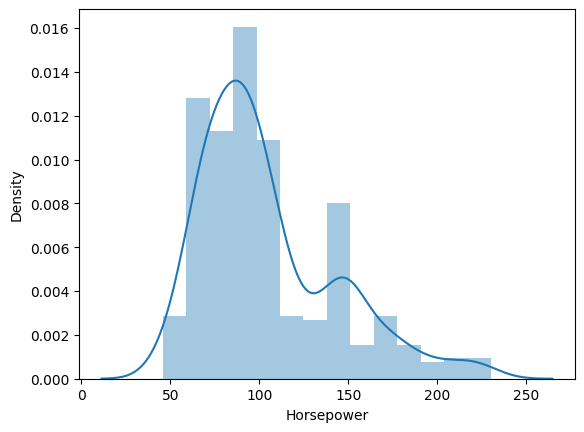

In [ ]:
sns.distplot(data.Horsepower);

<a id ="4"></a>
## Keşifsel-Açıklayıcı Veri Analizi (Exploratory Data Science)

In [ ]:
# nümerik özellikler var. bu özelliklerin arasındaki korelasyona bakalım
corr_matrix = data.corr()

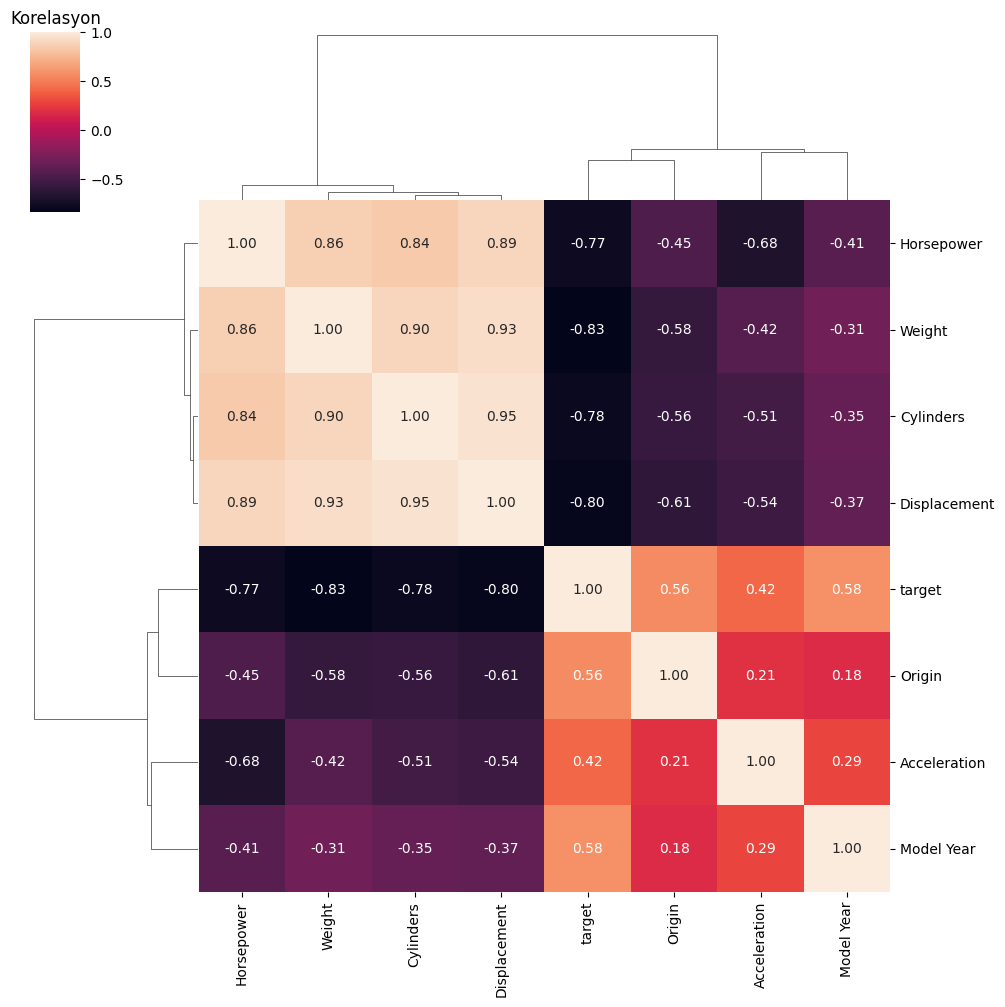

In [ ]:
sns.clustermap(corr_matrix, annot = True, fmt=".2f")
plt.title("Korelasyon")
plt.show()

* Horsepower, Weight, Cylinders, Displacement arasında yüksek pozitif korelasyon vardır. (beyaz)
* negatif korelasyon olduğu yerlerde var. (mor)
* bir araç ne kadar ağırsa hızlanmasıda o kadar yavaştır. weight ile acceleration arasında negatif korelasyon vardır yani ters orantılıdır
* target ile Horsepower, Weight, Cylinders, Displacement arasında yüksek negatif korelasyon vardır.

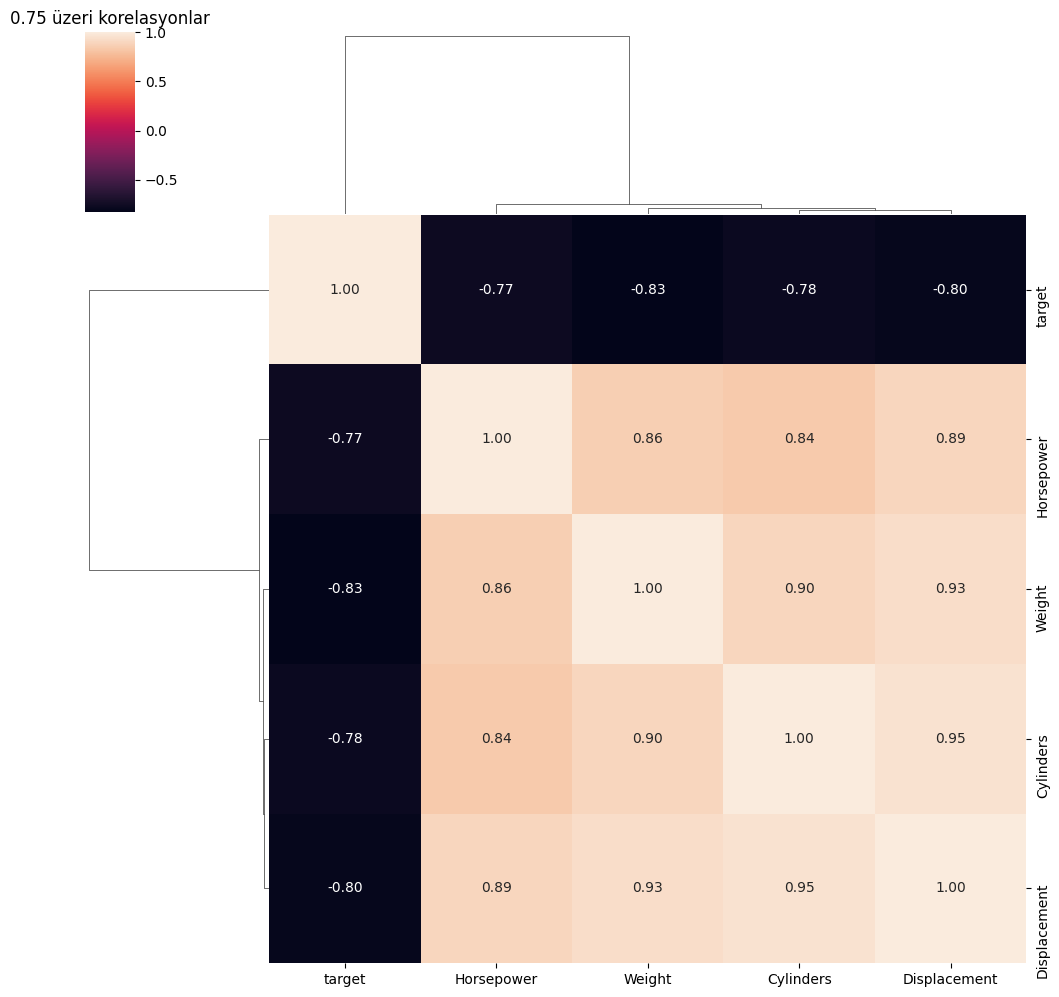

In [ ]:
# filtreyle 0.75 üzeri korelasyona sahip olan özellikleri görelim
threshold = 0.75

# negatif ve pozitif korelasyonların 0.75 üzeri olanları seçileceğinden mutlak değeri alıyorum
# target ile arasındaki negatif veya pozitif korelasyonu 0.75 üzeri olanları seç
filtre = np.abs(corr_matrix["target"]) > threshold

corr_features = corr_matrix.columns[filtre].tolist()

# datanın içerisindeki 0.75 üzeri korelasyonlar
sns.clustermap(data[corr_features].corr(), annot=True, fmt=".2f")

plt.title("0.75 üzeri korelasyonlar")
plt.show()

target ile arasında +/- 0.75 üzeri korelasyona sahip olan özellikler

birbirleriyle yüksek korelasyona sahip feature'lar birbirleriyle eş düzlemdir yani bunların arasında multicollinearity vardır, denebilir. bu dezavantajtır. çünkü multicollinearity birbirleriyle ilişkili birden çok özelliğin her birinin aynı şeyi söylediğini gösterir ve bu modeli yanlış yönlendirebilir. bir tanesi yeterlidir

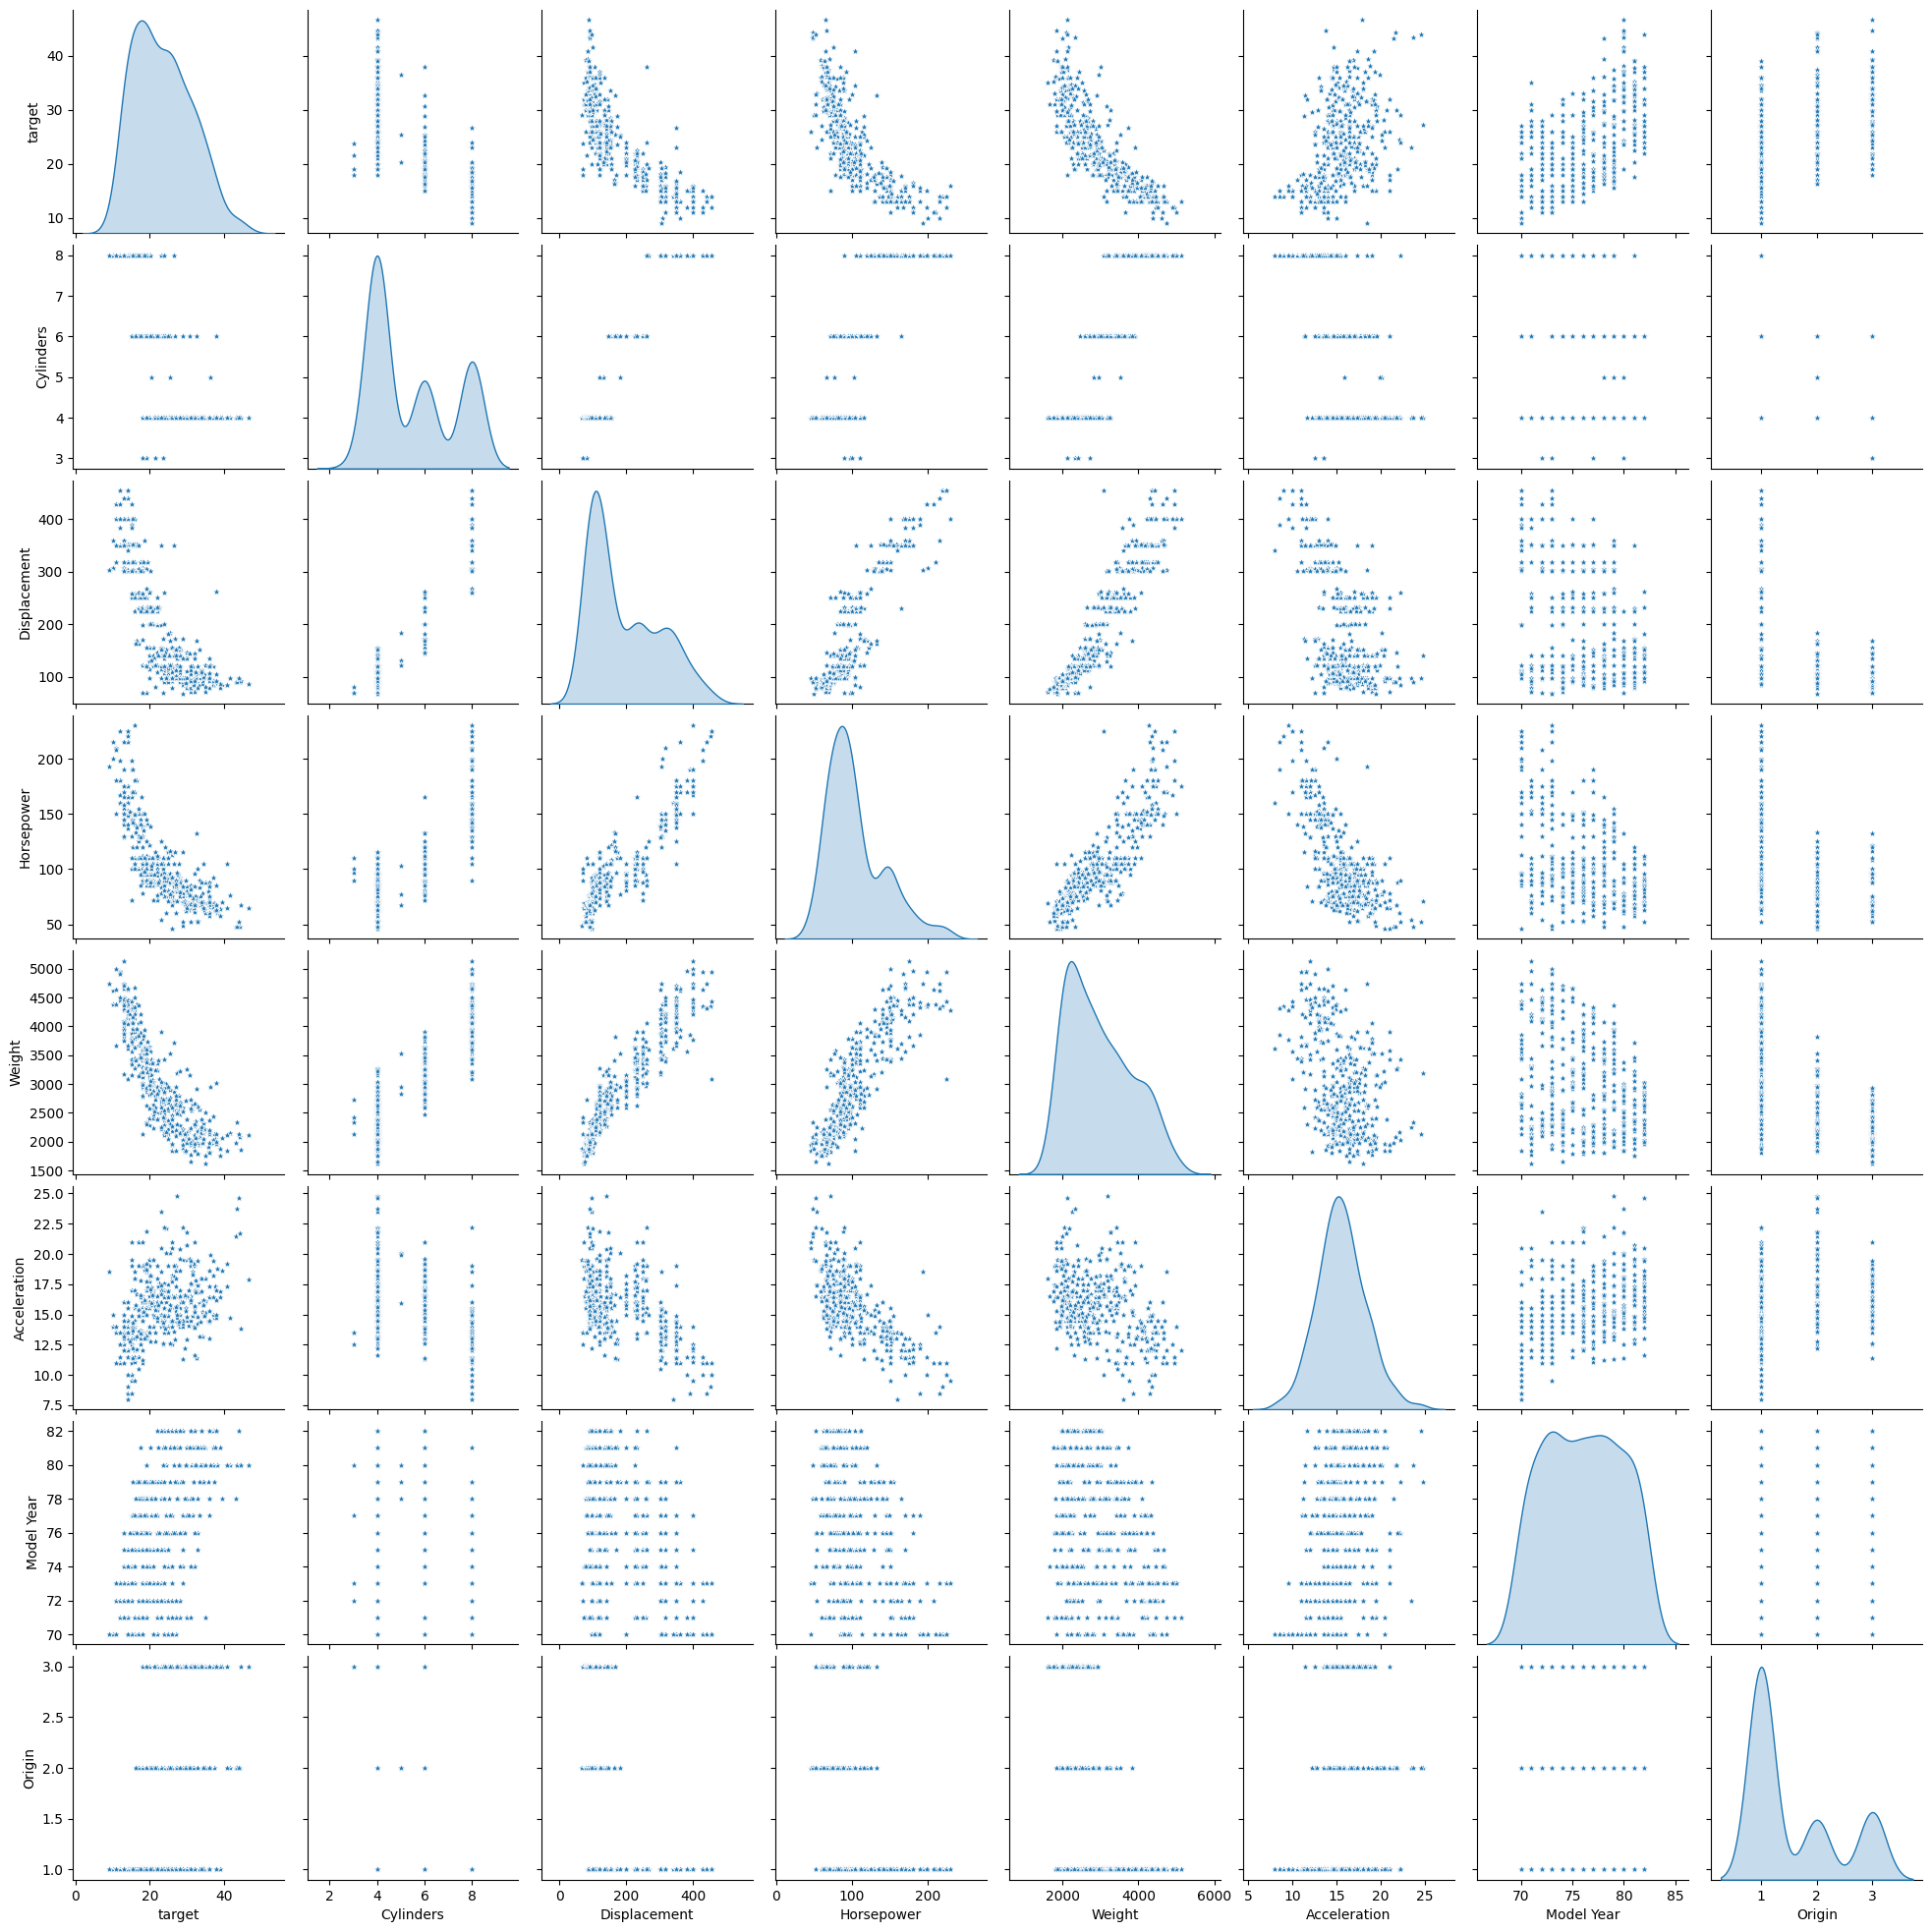

In [ ]:
# kde yoğunluk grafiği dağılımı gösterir diğerleri ise korelasyon grafiğidir
sns.pairplot(data, diag_kind="kde", markers="*")
plt.show()

* target'ın dağılımına baktığımızda sağa doğru uzayan bir kuyruk vardır. dolayısıyla burada pozitif çarpıklık vardır.
* target ile silindir arasındaki korelasyona baktığımızda silindirin 4, 6,  ve 8 değerleri var ve çok az 3 ve 5 değerlerinden de vardır yani silindiri kategorik bir değişken olarak düşünebiliriz
* target ile Displacement, Horsepower ve weight arasında ters orantı yani negatif korelasyon vardır.
* Displacement, Horsepower ve weight birbirleriyle aralarında pozitif korelasyon vardır.
* Acceleration ve Model Year ile target arasında herhangi bir korelasyon görülmemektedir.
* origin'de silindir gibi kategorik bir değişkendir.
* displacement'in dağılım grafiğine baktığımızda kuyruğu olduğu görülür dolayısıyla aykırı değerleri olabilir.

In [ ]:
# silindir ve origin kategorik olabilir (feature engineering)

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64


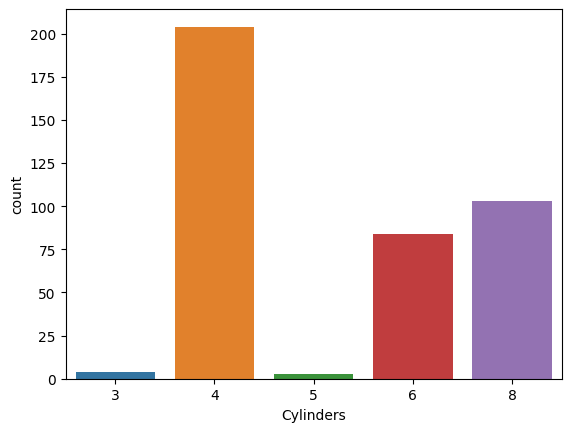

In [ ]:
plt.figure()
sns.countplot(x = data["Cylinders"])
print(data['Cylinders'].value_counts())
plt.show()

1    249
3     79
2     70
Name: Origin, dtype: int64


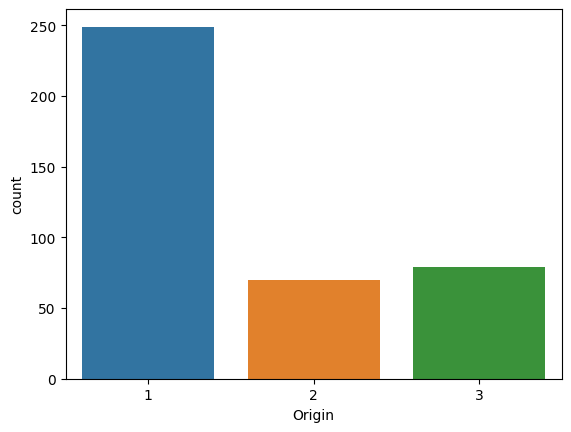

In [ ]:
plt.figure()
sns.countplot(x= data["Origin"])
print(data['Origin'].value_counts())
plt.show()

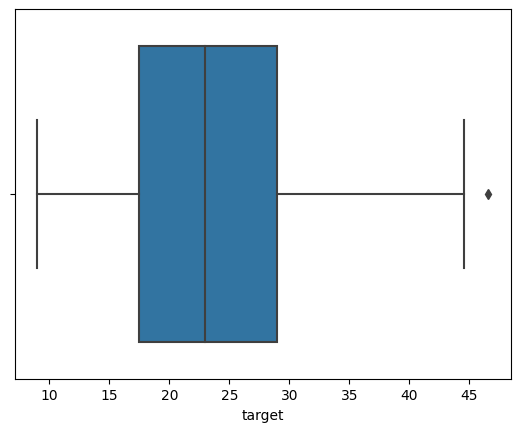

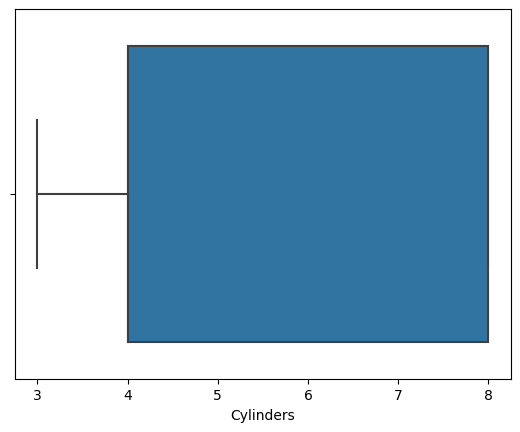

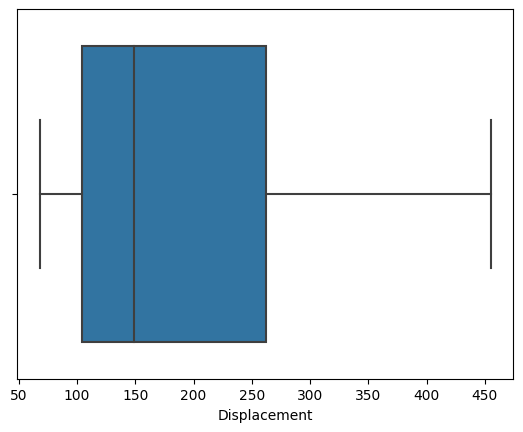

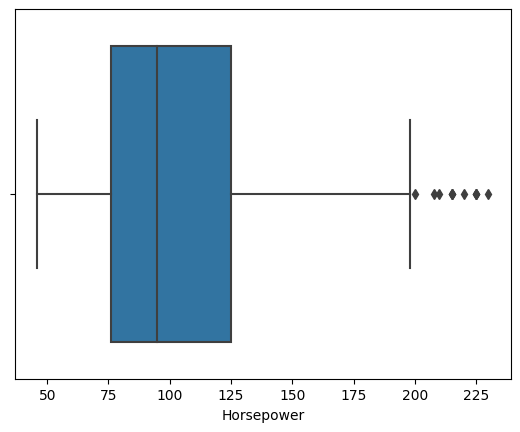

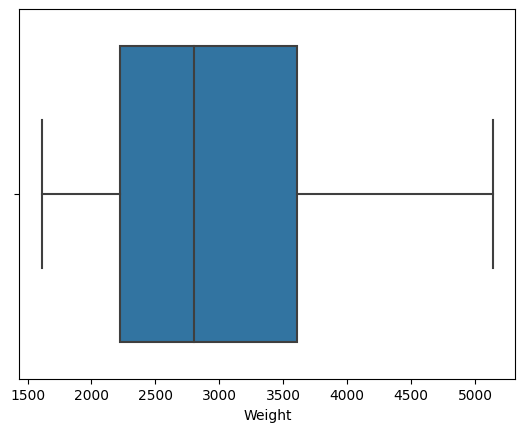

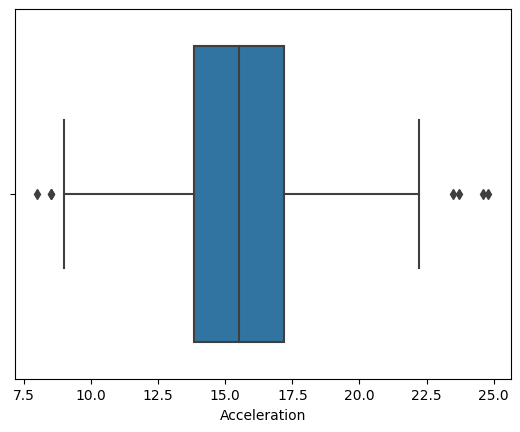

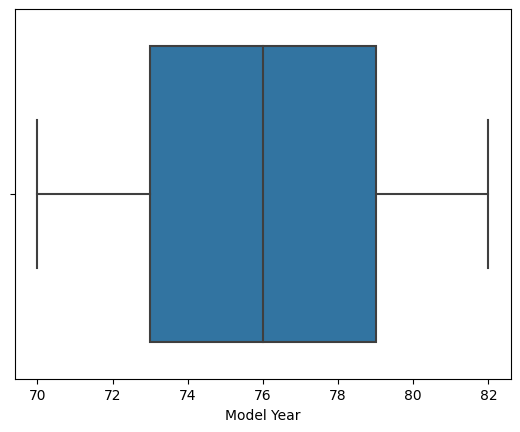

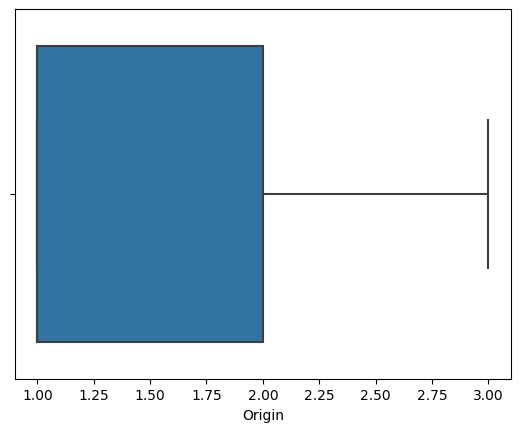

In [ ]:
# outlier'lara bakabilmek için boxplot'la devam edelim
for c in data.columns:
  plt.figure()
  sns.boxplot(x = c, data = data, orient="v") # vertical(dikey)
  plt.show()

* Acceleration ve Horsepower'da aykırı değerler görülür.
* target'da 1 tane var, düzelteceğiz.

<a id ="5"></a>
## Outlier'ların Tespiti ve Çıkarılması

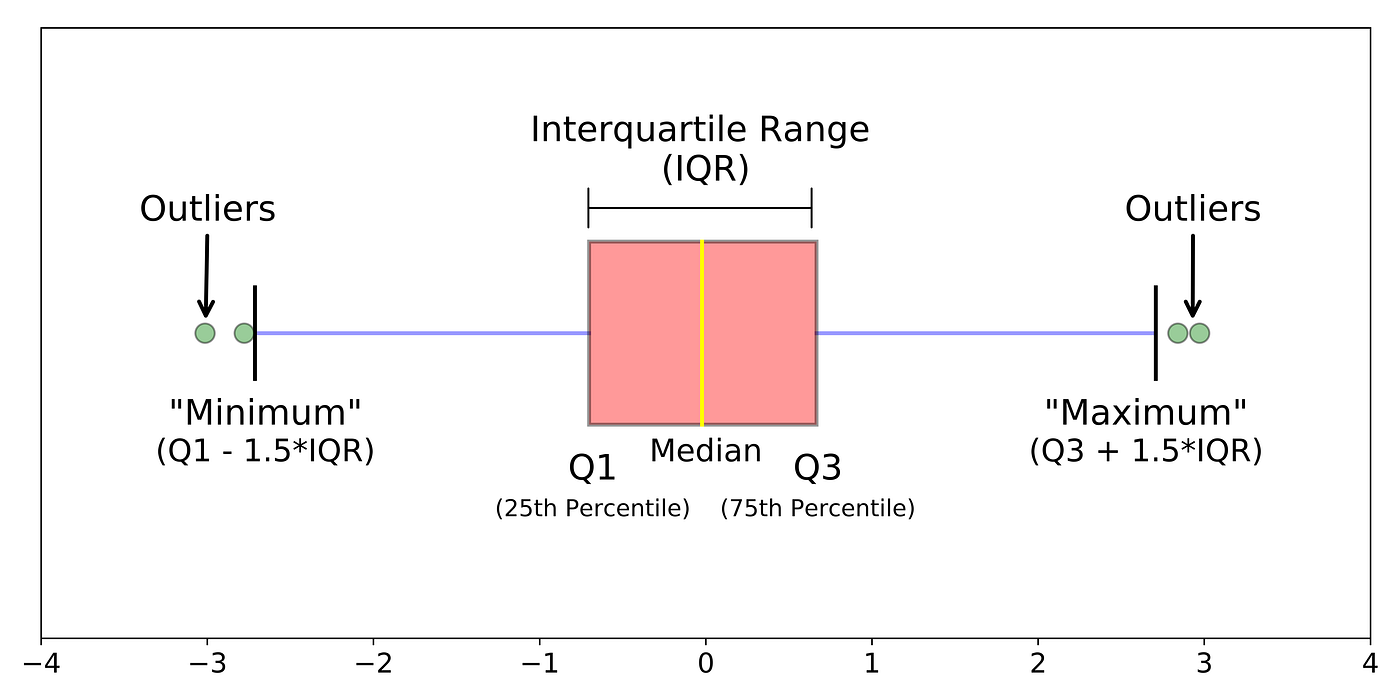

In [ ]:
data.shape

(398, 8)

In [ ]:
# Acceleration ve Horsepower'da aykırı değerler görülür.
# Aykırı değerler modeli yanlış yönlendirir
thr = 2 # 1.5

In [ ]:
horsepower_desc = describe["Horsepower"]
horsepower_desc

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: Horsepower, dtype: float64

In [ ]:
# Horsepower için aykırı değerleri bulalım
q3_hp = horsepower_desc[6] # %75
q1_hp = horsepower_desc[4] # %25

IQR_hp = q3_hp - q1_hp

max_limit_hp = q3_hp + IQR_hp*thr
min_limit_hp = q1_hp - IQR_hp*thr

# min ve max arasındaki değerler
filter_hp_max = max_limit_hp > data["Horsepower"] # max limitten küçük olan değerler
filter_hp_min = min_limit_hp < data["Horsepower"] # min limitten büyük olan değerler

filter_hp = filter_hp_max & filter_hp_min

data = data[filter_hp]

In [ ]:
acceleration_desc = describe["Acceleration"]
acceleration_desc

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: Acceleration, dtype: float64

In [ ]:
# Acceleration için aykırı değerleri bulalım
q3_acc = acceleration_desc[6] # %75
q1_acc = acceleration_desc[4] # %25

IQR_acc = q3_acc - q1_acc

max_limit_acc = q3_acc + IQR_acc*thr
min_limit_acc = q1_acc - IQR_acc*thr

# min ve max arasındaki değerler
filter_acc_max = max_limit_acc > data["Acceleration"] # max limitten küçük olan değerler
filter_acc_min = min_limit_acc < data["Acceleration"] # min limitten büyük olan değerler

filter_acc = filter_acc_max & filter_acc_min

data = data[filter_acc]

In [ ]:
data.shape

(395, 8)

<a id ="6"></a>
## Feature Enginnering (Öz Nitelik Mühendisliği): Skewness (Çarpıklık)

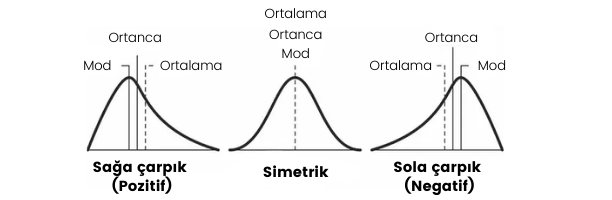

* Normal dağılımın özelliği ortalama, medyan ve mod değerlerinin hepsi birbirine eşitti ve ortalama etrafında simetrik yapıya sahipti
* çarpıklık, normal dağılıma göre sağa veya sola doğru bir kuyruğu vardır.
* eğer sağda kuyruk varsa sağa çarpık veya pozitif çarpık denir.
* eğer solda kuyruk varsa sola çarpık veya negatif çarpık denir.
* verinin 3. momenti çarpıklık değerini verir. 1. moment ortalama, 2. moment standart sapma ve 3. momentin standardize edilmiş hali ise standardize edilmiş çarpıklık değerini verir.
* çarpıklık değeri > 1 ise pozitif çarpık
* çarpıklık değeri < -1 ise negatif çarpık
* çarpıklık verinin kuyruk bölgesindeki veriler aykırı değerler olarak adlandırılırlar. kuyruk bölgesindeki veriler outlier olarak modeli olumsuz etkileyebilir.
* outlier regresyon modellerini olumsuz etkiler bu nedenle çarpık verileri normal dağılıma yakınlaştırmalıyız yani çarpıklıklarını azaltmalıyız. bu modelin daha başarılı olmasını sağlar.
* çarpıklığı, normal dağılıma dönüştürebilmek için log yöntemi kullanılabilir

In [ ]:
# çarpıklık
# verinin içerisindeki bağımlı ve bağımsız değişkenlerin çarpıklık değerlerine bakalım

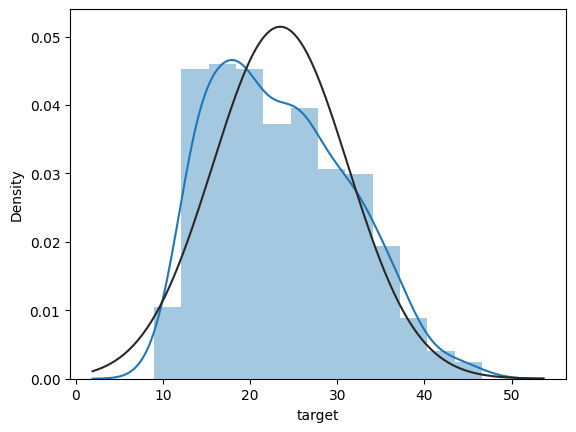

In [ ]:
# target, bağımlı değişken
# normal dağılımla karşılaştırabilmek için fit=norm
sns.distplot(data.target, fit = norm) # histogram ile yoğunluk grafiği dağılımı gösterir
plt.show()

* kuyruk sağ tarafta, sağa çarpık yani pozitif çarpıklık vardır.
* normal dağılım siyah ile gösterilmiştir.

In [ ]:
# target'ın sigma ve mu değerlerine bakalım
(mu, sigma) = norm.fit(data["target"])
print("mu = {}, sigma = {}".format(mu, sigma))

mu = 23.472405063291134, sigma = 7.756119546409932


mu ortalamayı, sigma ise standart sapmayı belirtir. ortalama 0'a, standart sapma ise 1'e yaklaştıkça normal dağılıma yaklaşılır.

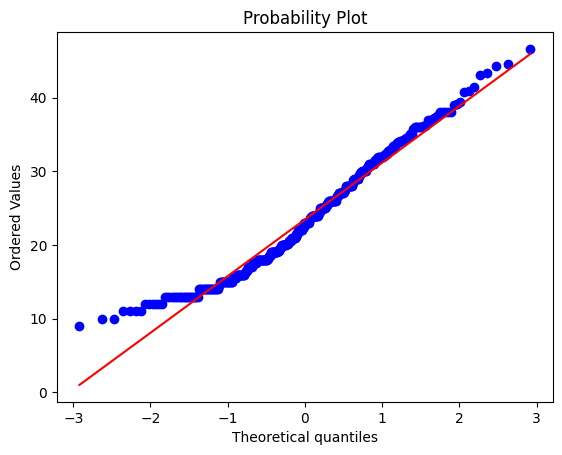

In [ ]:
# dağılımın normal dağılım olup olmadığını qqplot'a bakarak anlayabiliriz
plt.figure()
stats.probplot(data["target"], plot=plt)
plt.show()

* ordered value: verinin çeyrekleri(%25, %50, %75)
* theoretical quantiles: normal dağılıma ait çeyrekler
* verinin kırmızı çizgiye aynı olması gerekiyordu, veri kırmızı çizginin üzerinde olsaydı normal dağılıma sahiptir diyebilecektik.
* özellikle uç noktalarda verinin normalliğini kaybettiğini görebiliyoruz

In [ ]:
# çarpıklık değerini azaltabilmek için log yöntemini kullanacağız
data["target"] = np.log1p(data["target"])

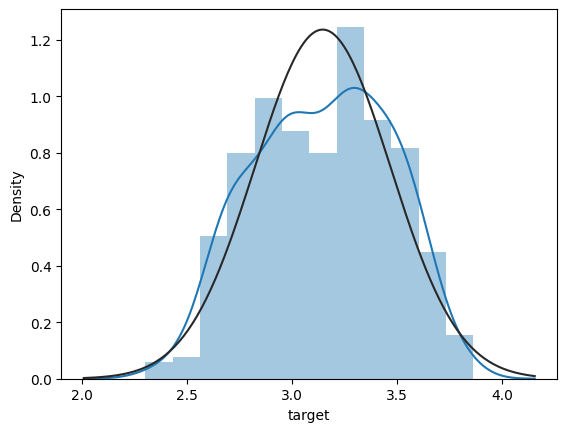

In [ ]:
plt.figure()
sns.distplot(data.target, fit = norm) # histogram ile yoğunluk grafiği dağılımı gösterir
plt.show()

* normal dağılım siyah renkli, veri ise mavi renkli
* mavi, normale yaklaşmıştır ve çarpıklık değerinin azaldığı gözlemlenmektedir.

In [ ]:
(mu, sigma) = norm.fit(data["target"])
print("mu = {}, sigma = {}".format(mu, sigma))

mu = 3.146474056830183, sigma = 0.3227569103044822


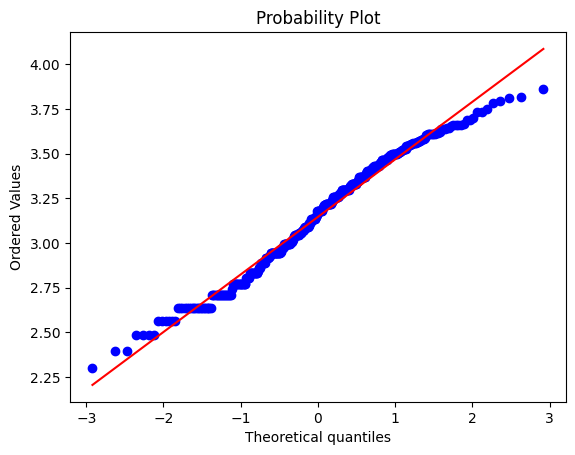

In [ ]:
# dağılımın normal dağılım olup olmadığını qqplot'a bakarak anlayabiliriz
plt.figure()
stats.probplot(data["target"], plot=plt)
plt.show()

Normale daha çok yaklaşıldığı gözlemlenmektedir.

In [ ]:
# bağımsız değişkenlerin çarpıklık değerlerine bakalım
# data içindeki her bir sütunun (her bir özellik veya değişken) çarpıklık (skewness)
# değerini hesaplar ve bu çarpıklık değerlerini büyükten küçüğe sıralar.
# x.dropna() ile her sütundan eksik (NaN) değerlerin çıkarılması sağlanır.
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

In [ ]:
skewness = pd.DataFrame(skewed_feats, columns=["skewed"])
skewness

,skewed
Horsepower,1.067743
Origin,0.923381
Displacement,0.714682
Weight,0.533226
Cylinders,0.523374
Acceleration,0.168986
Model Year,0.013098
target,-0.117687


* çarpıklık değeri > 1 ise pozitif çarpık
* çarpıklık değeri < -1 ise negatif çarpık
* Horsepower'da pozitif çarpıklık var fakat çarpıklık değeri 1'e çok yakın olduğundan dolayı ihmal edebiliriz.
* -1'den küçük bir değer yok
* target değişkeni düzeltildiği için çarpıklık değeri 0'a yakın bir değerdir.
* çarpık olan değişkenleri box cox transformation yöntemiyle düzeltebiliriz, çarpıklık değerlerini azaltabiliriz.

<a id ="7"></a>
## Feature Enginnering (Öz Nitelik Mühendisliği): One Hot Encoding

origin değişkeni nümerik olmasına rağmen kategorik olarak değerlendirip, one hot encoding yapacağız. origin 1, 2 ve 3 değerlerine sahiptir. one hot encoding işlemi uyguladıktan sonra origin özelliği ortadan kalkar origin1, origin2 ve origin3 olmak üzere 3 tane özellik oluşur.

<!DOCTYPE html>
<html>
<head>
    <title>One Hot Encoding</title>
</head>
<body>
    <table>
        <tr>
            <th>origin</th>
            <th>origin 1</th>
            <th>origin 2</th>
            <th>origin 3</th>
        </tr>
        <tr>
            <th>1</th>
            <td>1</td>
            <td>0</td>
            <td>0</td>
        </tr>
        <tr>
            <th>2</th>
            <td>0</td>
            <td>1</td>
            <td>0</td>
        </tr>
        <tr>
            <th>3</th>
            <td>0</td>
            <td>0</td>
            <td>1</td>
        </tr>
    </table>
</body>
</html>


One Hot Encoding işleminin yapılmasının nedeni, origin değişkenindeki kategorik veriler modeli bozar.

In [ ]:
# Cylinders ve origin değişkenini one hot encoding

In [ ]:
# Cylinders ve origin değişkenini kategorik değişkene dönüştürelim
data['Cylinders'] = data['Cylinders'].astype(str) # str, object'di. kategorik veriler object'lerden oluşuyor.
data['Origin'] = data['Origin'].astype(str)

# get_dummies fonksiyonu data'nın içerisindeki kategorik değişkenleri One Hot Encoding işlemine tabii tutar
data = pd.get_dummies(data)
data[:5]

,target,Displacement,Horsepower,Weight,Acceleration,Model Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0


* Origin ortadan kalktı yerine Origin_1, Origin_2 ve Origin_3 geldi.
* Cylinders'de aynı şekilde ortadan kalktı ve Cylinders_3	, Cylinders_4, Cylinders_5, Cylinders_6 ve Cylinders_8 geldi. 3, 4, 5, 6 ve 8 şeklinde adlandırılmasının nedeni bu sayıların önceden Cylinders'in değerleri olmasıdır.

<a id ="8"></a>
## Preprocess: Eğitim/Test Verisinin Ayrılması ve Standardizasyon

In [ ]:
x = data.drop(["target"], axis=1)
y = data.target

In [ ]:
print("data.shape:", data.shape)
print("x.shape:", x.shape)
print("y.shape:", y.shape)

data.shape: (395, 14)
x.shape: (395, 13)
y.shape: (395,)


In [ ]:
test_size = 0.9 # verinin %90'ını test veri seti olarak kullanacağım

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = test_size,
                                                    random_state = 42)

In [ ]:
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: (39, 13)
y_train.shape: (39,)
x_test.shape: (356, 13)
y_test.shape: (356,)


In [ ]:
# Standardizasyon

In [ ]:
scaler = StandardScaler() # RobustScaler
x_train = scaler.fit_transform(x_train) # scaler, x_train'e göre fit edildi, eğitildi
# x_train ile fit ettiğim scaler ile x_test Standardize edildi
x_test = scaler.transform(x_test)

<a id ="9"></a>
## Linear Regression (Doğrusal Regresyon)

Lineer regresyon, bir bağımlı değişken (genellikle "y" olarak temsil edilir) ile bir veya daha fazla bağımsız değişken (genellikle "x" olarak temsil edilir) arasındaki ilişkiyi incelemek ve bu ilişkiyi temsil eden bir doğru (regresyon çizgisi veya regresyon eğrisi olarak da adlandırılır) bulmak için kullanılan bir istatistiksel yöntemdir.

Lineer regresyon, least squares yöntemi kullanılarak uygulanır. Least squares yöntemi, veri noktaları ile regresyon çizgisi arasındaki hata veya sapmayı ölçer ve bu sapmaların karelerinin toplamını (Sum of Squared Errors - SSE) minimize etmeye çalışır. Bu yöntem, regresyon çizgisini veriye en iyi uyan çizgiyi bulmak için kullanılır.

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train) # model eğitildi

LinearRegression()

In [ ]:
# lineer katsayıları
print("LR Coef:", lr.coef_)

LR Coef: [-9.92705759e-02 -1.05006197e-01 -2.28689229e-02 -4.99057559e-02
  4.34952012e-02 -5.72828846e-02  4.72375426e-02 -3.46944695e-17
 -1.40612813e-02 -2.28840651e-02 -7.11143569e-03 -2.73464310e-02
  3.45783731e-02]


In [ ]:
# x_test veri setini kullanılarak tahmin işlemi gerçekleşiyor
y_predicted_dummy = lr.predict(x_test)

In [ ]:
# hata kareler ortalaması hesaplanır
mse = mean_squared_error(y_test, y_predicted_dummy) # gerçek değerler, tahmin değerleri

In [ ]:
# hata kareler ortalaması
print("Linear Regression MSE:", mse) # hata değeri

Linear Regression MSE: 0.020632204780133036


<a id ="10"></a>
## Regularization 1: Ridge Regression

Regularization tekniği, ebzerlemeyi(overfitting) engellemeye yardımcı olan tekniktir.

Ridge Regression bir Regularization yöntemidir. Regularization yöntemleri overfitting'i önler, varyansı azaltan yöntemlerdir.

In [ ]:
ridge = Ridge(random_state=42,
              max_iter = 10000) # yapacağı max eğitim sayısı

In [ ]:
# lambda değerini optimum olarak seçebilmek için GridSearchCV yöntemini kullanırız
alphas = np.logspace(-4, -0.5, 30) # -4'den -0.5'e kadar 30 tane değer oluştursun

In [ ]:
# lambda'nın en optimum değerini bulacağım
# GridSearchCV, sözlük olarak alır
tuned_parameters = [{"alpha": alphas}]

In [ ]:
n_folds = 5
clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit=True)
# refit: clf'yi daha sonrada herhangi bir şeyi test etmek için kullanmak için True
# eğer false ise clf bir daha kullanılamaz

* refit=True ile Modelin En İyi Hiperparametrelerle Tekrar Eğitilmesi:
  * refit=True ayarı, GridSearchCV'nin en iyi hiperparametre kombinasyonlarını bulduktan sonra bu kombinasyonlarla modeli tekrar eğitmesini sağlar. Yani, en iyi modeli bulduktan sonra bu modeli kullanılabilir hale getirir.

In [ ]:
# eğitim
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(max_iter=10000, random_state=42),
             param_grid=[{'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])}],
             scoring='neg_mean_squared_error')

In [ ]:
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

In [ ]:
# katsayılarına bakalım
print("Ridge Coef:", clf.best_estimator_.coef_)

Ridge Coef: [-0.07849695 -0.09734007 -0.03799319 -0.04613241  0.04520109 -0.0535352
  0.05108925  0.         -0.01455674 -0.02919833 -0.00857541 -0.02556196
  0.03459116]


In [ ]:
ridge = clf.best_estimator_
print("Ridge Best Estimator:", ridge) # en iyi parametreler

# clf'yi kullanabiliyor olmamın nedeni refit=True olması, False olsaydı kullanılamazdı
# clf zaten otomatik bir şekilde en iyi parametreleri kullanarak gerçekleştirecek
y_predicted_dummy = clf.predict(x_test) # tahmin

mse = mean_squared_error(y_test, y_predicted_dummy)
print("Ridge MSE:", mse)

Ridge Best Estimator: Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE: 0.019725338010801202


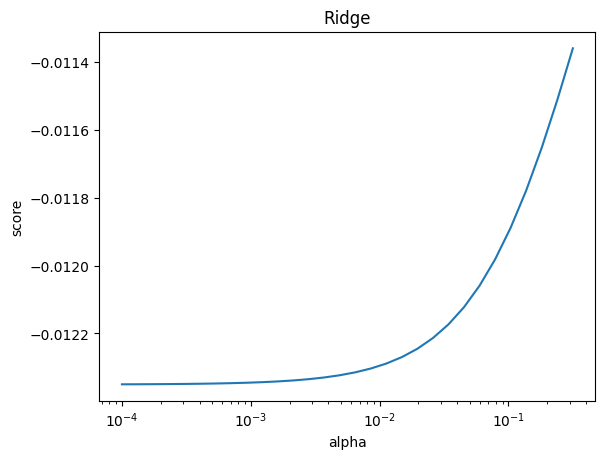

In [ ]:
# lambda'nın skora göre nasıl değiştiğini gözlemleyelim
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")
plt.show()

<a id ="11"></a>
## Regularization 2: Lasso Regression

Lasso'nun Ridge'den farkı, Lasso'da gereksiz özelliklerin (feature'ların) katsayılarının (coef) 0 olarak atanmasıdır. Ridge'de ise katsayılar sıfıra yaklaştırılır, ancak tam olarak sıfır yapılmazlar.

Lasso'da bir bağımsız değişkenin katsayısı sıfır atanırsa, bu bağımsız değişkenin bağımlı değişkene etkisi olmadığı anlamına gelir, yani o özelliği kullanmak gerekmez.

Lasso'nun diğer bir avantajı, yüksek korelasyonlu özellikler varsa, Lasso sadece bu özelliklerden birini seçer ve diğerlerinin katsayılarını sıfır yapar. En önemli özelliği seçer.

Lasso'da Ridge'de olduğu gibi biraz bias vardır. Train veri setiyle arasında biraz bias oluşur. Ancak varyans açısından Ridge'ye göre daha düşüktür, yani Lasso overfitting'i Ridge gibi önler.

Zaten düzenlileştirmenin (regularization) temel amacı overfitting'i engellemektir.

In [ ]:
# modeli oluşturuldu
lasso = Lasso(random_state=42, max_iter=10000)

In [ ]:
# hiperparametre olan lambda yani alfa değerleri
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]

In [ ]:
# lambda değerinin seçilmesi için GridSearchCV yöntemini kullandım
n_folds = 5
clf = GridSearchCV(lasso, # model
                   tuned_parameters, # hiperparametreler ve denenecek değerleri (lambda)
                   cv=n_folds, # 5
                   scoring="neg_mean_squared_error", # göre değerlendirme yapacak
                   refit=True) # ileride kullanmak için

In [ ]:
clf.fit(x_train, y_train) # eğitim

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=42),
             param_grid=[{'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])}],
             scoring='neg_mean_squared_error')

In [ ]:
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

In [ ]:
# katsayılar
print("Lasso Coef:", clf.best_estimator_.coef_)

Lasso Coef: [-0.03758778 -0.08757891 -0.0646061  -0.02803523  0.0491826  -0.03359315
  0.071679    0.          0.         -0.01794883 -0.         -0.00408397
  0.04250482]


In [ ]:
lasso = clf.best_estimator_ # en optimum hiperparametre değerleri
print("Lasso Best Estimator:", lasso)

Lasso Best Estimator: Lasso(alpha=0.004893900918477494, max_iter=10000, random_state=42)


In [ ]:
# tahmin işlemi
y_predicted_dummy = clf.predict(x_test)

In [ ]:
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Lasso MSE:", mse)

Lasso MSE: 0.017521594770822498


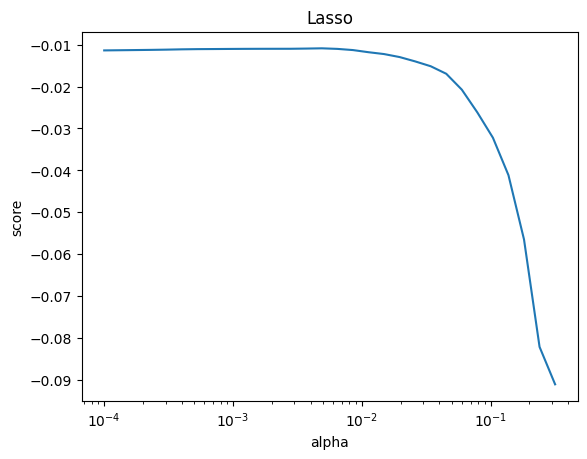

In [ ]:
# lambda değerinin skora göre değişiminin görselleştirilmesi
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")
plt.show()

* Lasso Coef: [-0.03758778 -0.08757891 -0.0646061  -0.02803523  0.0491826  -0.03359315
  0.071679    0.          0.         -0.01794883 -0.         -0.00408397
  0.04250482]
* Lasso MSE: 0.017521594770822498
* Lasso'nun katsayılarında 0 değerleri var, Ridge'de katsayılar 0 olamazdı.
* Lasso gereksiz olan özelliklerin katsayılarına direkt 0 değerini atar. Sadece gereklileri kullanır.
* Lasso MSE: 0.017 çıkmış yani şimdiye kadarki en iyi değere ulaşıldı. Lasso en iyi değeri vermiş oldu.

<a id ="12"></a>
## Regularization 3: ElasticNet

ElasticNet ise Lasso ve Ridge'in karışımıdır. Her ikisininde kuvvetli yönlerine sahiptir. Dolayısıyla 2 farklı hiperparametreye sahiptir.

ElasticNet'in avantajları yüksek korelasyonlu özelliklerin çıkartılmasında kullanılır. korelasyonu azaltır.

In [ ]:
parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

In [ ]:
eNet = ElasticNet(random_state=42, max_iter=10000)

In [ ]:
clf = GridSearchCV(eNet,
                   parametersGrid,
                   cv=n_folds,
                   scoring="neg_mean_squared_error",
                   refit=True)

In [ ]:
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000, random_state=42),
             param_grid={'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_mean_squared_error')

In [ ]:
print("ElasticNet Coef:", clf.best_estimator_.coef_)

ElasticNet Coef: [-0.04521908 -0.07808085 -0.06742275 -0.024673    0.04776549 -0.03439345
  0.06689553  0.         -0.         -0.01879676 -0.         -0.00575413
  0.03999268]


In [ ]:
eNet = clf.best_estimator_
print("ElasticNet Best Estimator:", eNet)

ElasticNet Best Estimator: ElasticNet(alpha=0.04520353656360245, l1_ratio=0.1, max_iter=10000,
           random_state=42)


In [ ]:
y_predicted_dummy = clf.predict(x_test)

In [ ]:
mse = mean_squared_error(y_test, y_predicted_dummy)
print("ElasticNet MSE:", mse)

ElasticNet MSE: 0.017496092493172508


* Linear Regression MSE: 0.020632204780133036
* Ridge MSE: 0.019725338010801202
* Lasso MSE: 0.017521594770822498
* ElasticNet MSE: 0.017496092493172508

*en iyi değer, ElasticNet ile buldu.*

Bu değerler bulunurken StandartScaler yöntemi kullanılmıştı. RobustScaler kullanıldığında sonuçlar:
* Linear Regression MSE: 0.02048705828077559
* Ridge MSE: 0.01937186998245176
* Lasso MSE: 0.018707192302889197
* ElasticNet MSE: 0.018658206816964746

StandartScaler sonuçları daha iyi olduğundan StandartScaler kullanılacak.

* _**StandardScaler**_:
StandardScaler, bir özellik (sütun) içindeki değerleri ortalamayı kaldırarak ve standart sapmayı birim olarak ayarlayarak ölçeklendirir. Yani, her özellik için ortalama değer sıfır olur ve standart sapma bir olur. Bu, verinin yaklaşık olarak normal dağıldığı ve aykırı değerlerin olmadığı durumlar için uygundur. Veriler normal bir dağılıma sahipse, bu yöntem genellikle iyi sonuçlar verir.
* _**RobustScaler**_:
RobustScaler, bir özelliğin değerlerini medyanı kaldırarak ve veriye özgü bir ölçekleme işlemi kullanarak ölçeklendirir. Medyan, verinin ortasındaki değerdir ve aykırı değerlere karşı daha dayanıklıdır çünkü medyanın hesaplanması sırasında en düşük ve en yüksek değerlere bakılmaz. Bu nedenle, aykırı değerlerin olduğu veri kümeleri için daha uygundur. RobustScaler, verilerin normal dağılıma sahip olmadığı veya aykırı değerler içerdiği durumlarda tercih edilir.

<a id ="13"></a>
## XGBoost

XGBoost büyük, karmaşık veri setleri için dizayn edilmiş bir algoritmadır. Çok karmaşık bir modeldir.

In [ ]:
parametersGrid = {'nthread':[4],
                  'objective':["reg:linear"],
                  'learning_rate':[.03, 0.05, .07],
                  "max_depth":[5,6,7],
                  "min_child_weight":[4],
                  "silent":[1],
                  "subsample":[0.7],
                  "colsample_bytree":[0.7],
                  "n_estimators":[500, 1000]}

Bu parametreler, XGBoost modelinin çeşitli hiperparametrelerini ve bu hiperparametrelerin farklı değerlerini içeren bir parametre gridini temsil eder. Bu grid, çeşitli hiperparametre kombinasyonlarını denemek ve en iyi performansı sağlayan kombinasyonu seçmek için kullanılabilir. İşte bu parametrelerin her birinin anlamı:

1. `nthread`: Eğitim sırasında kullanılacak iş parçacığı (thread) sayısını belirtir. Bu, eğitim işlemini hızlandırmak için çoklu işlemcili sistemlerde kullanılabilir. Burada `4` olarak ayarlandı.

2. `objective`: Modelin hangi amaçla eğitileceğini belirtir. "reg:linear" olarak ayarlandığında, model lineer regresyon problemlerini çözmek için eğitilecektir.

3. `learning_rate`: Her bir ağacın tahminini ne kadar düzelteceğini kontrol eden öğrenme oranını belirtir. Grid içinde farklı değerler denenecektir: 0.03, 0.05 ve 0.07.

4. `max_depth`: Her bir ağacın maksimum derinliğini belirtir. Grid içinde farklı değerler denenecektir: 5, 6 ve 7.

5. `min_child_weight`: Bir yapının ağaçta bölünmesi için gereken minimum örnek sayısını belirtir. Bu değer `4` olarak ayarlandı.

6. `silent`: Eğitim sırasında modelin çalışma durumuyla ilgili bilgilendirme metinlerinin görüntülenip görüntülenmeyeceğini belirtir. `1` olarak ayarlandığında, sessiz modda çalışır.

7. `subsample`: Her eğitim aşamasında kullanılacak alt veri kümesinin boyutunu belirtir. Burada `0.7` olarak ayarlandı, yani her bir eğitim aşamasında verilerin %70'i rastgele seçilir.

8. `colsample_bytree`: Her ağaç için sütunların (özelliklerin) ne kadarının rastgele seçileceğini belirtir. Bu, ağaçların çeşitliliğini artırmak ve aşırı uydurmayı azaltmak için kullanılır. Burada `0.7` olarak ayarlandı, yani her ağaç için özelliklerin %70'i rastgele seçilir.

9. `n_estimators`: Kullanılacak olan ağaç sayısını belirtir. Grid içinde farklı değerler denenecektir: 500 ve 1000.

Bu parametre gridi, farklı hiperparametre kombinasyonlarını deneyerek XGBoost modelinin performansını iyileştirmek için kullanılır. İyi bir hiperparametre kombinasyonu seçmek, modelin daha iyi tahminler yapmasını sağlayabilir. Grid araması genellikle çapraz doğrulama (cross-validation) ile birlikte kullanılır, böylece en iyi sonuç veren hiperparametreler seçilebilir.

In [ ]:
# model oluşturuldu
model_xgb = xgb.XGBRegressor()

In [ ]:
# GridSearchCV
n_folds =5

clf = GridSearchCV(model_xgb,
                   parametersGrid,
                   cv=n_folds,
                   scoring="neg_mean_squared_error",
                   refit=True,
                   n_jobs=5,
                   )

In [ ]:
clf.fit(x_train, y_train) # eğitim

[16:28:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500, 1000], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             scoring='neg_mean_squared_error')

In [ ]:
# en optimum parametreler
model_xgb = clf.best_estimator_

In [ ]:
y_predicted_dummy = clf.predict(x_test) # tahmin

In [ ]:
mse = mean_squared_error(y_test, y_predicted_dummy)
print("XGBRegressor MSE:", mse)

XGBRegressor MSE: 0.017575412886209233


<a id ="14"></a>
## Modellerin Ortalaması (Averaging Models)

- Lasso MSE: 0.017521594770822498
- ElasticNet MSE: 0.017496092493172508
- XGBRegressor MSE: 0.017575412886209233

En iyi sonuçlar bu 3 modelde elde edildiğinden bu 3 modeli kullanacağız.

Tahminlerin ortalamalarını alacağız ve test skorunu bulacağız.

In [ ]:
class AveragingModels():
  def __init__(self, models):
    self.models = models # 3 modeli kullanacağım

  def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models] # modeller

    for model in self.models_:
      model.fit(X, y) # her bir model eğitilir

    return self

  def predict(self, X):
    predictions = np.column_stack([model.predict(X) for model in self.models_]) # tahmin işlemi gerçekleşir
    return np.mean(predictions, axis=1) # tahminlerin ortalaması alınır

In [ ]:
# nesne oluşturuldu
averaged_models = AveragingModels(models = (model_xgb, eNet, lasso))

In [ ]:
# fit fonksiyonu çağrıldı ve eğitim gerçekleştirildi
averaged_models.fit(x_train, y_train)

[16:28:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [ ]:
# predict fonksiyonu çağrıldı
# tahmin işlemi gerçekleştirilip tahminlerin ortalaması geri dönderildi
y_predicted_dummy = averaged_models.predict(x_test)

In [ ]:
# MSE hesaplayalım
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Averaged Models MSE:", mse)

Averaged Models MSE: 0.016448125669438204


Averaged Models MSE: 0.016448125669438204
* En iyi sonuç Averaged Models ile bulundu.